In [ ]:
#set root drive path for Google Drive which has all data including x ray images.
#Data downloaded from Kaggle. Url: https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge/data
ROOT = "/content/drive/"


In [ ]:
from os.path import join
import os

# path to your project on Google Drive
PneumoniaData = 'MyDrive/pneumonia-detection/'
trainData = 'stage_2_train_images/'
savedFolder = 'Saved_Data/'

PROJECT_PATH = join(ROOT, PneumoniaData)
TRAIN_PATH = join(PROJECT_PATH, trainData)
SAVE_PATH = join(PROJECT_PATH, savedFolder)
GIT_LOCAL_PATH = join(PROJECT_PATH, 'git/')

# It's good to print out the value if you are not sure
print("PROJECT_PATH: ", PROJECT_PATH)
print("TRAIN_PATH: ", TRAIN_PATH)
print("SAVE_PATH: ", SAVE_PATH)
print("GIT_LOCAL_PATH: ", GIT_LOCAL_PATH)

# In case we haven't created the folder already; we will create a folder in the project path
%mkdir "{PROJECT_PATH}"

PROJECT_PATH:  /content/drive/MyDrive/pneumonia-detection/
TRAIN_PATH:  /content/drive/MyDrive/pneumonia-detection/stage_2_train_images/
SAVE_PATH:  /content/drive/MyDrive/pneumonia-detection/Saved_Data/
GIT_LOCAL_PATH:  /content/drive/MyDrive/pneumonia-detection/git/
mkdir: cannot create directory ‘/content/drive/MyDrive/pneumonia-detection/’: File exists


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd

classInfo = pd.read_csv('/content/drive/MyDrive/pneumonia-detection/stage_2_detailed_class_info.csv')
print(classInfo.shape)
print(classInfo.head())

labels = pd.read_csv('/content/drive/MyDrive/pneumonia-detection/stage_2_train_labels.csv')
print(labels.shape)
print(labels.head())

(30227, 2)
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
(30227, 6)
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


In [ ]:
print('\nTotal Patients in class info:\n',len(classInfo['patientId']))
print('\nTotal Patients in labels:\n',len(labels['patientId']))

print('\nUnique Patients in class info:\n',len(classInfo['patientId'].unique()))
print('\nUnique Patients in labels:\n',len(labels['patientId'].unique()))


Total Patients in class info:
 30227

Total Patients in labels:
 30227

Unique Patients in class info:
 26684

Unique Patients in labels:
 26684


In [ ]:
# Remove duplicate entries
labels = labels.drop_duplicates("patientId")
classInfo = classInfo.drop_duplicates("patientId")


In [ ]:
print('\nTotal Patients in class info:\n',len(classInfo['patientId']))
print('\nTotal Patients in labels:\n',len(labels['patientId']))

print('\nUnique Patients in class info:\n',len(classInfo['patientId'].unique()))
print('\nUnique Patients in labels:\n',len(labels['patientId'].unique()))


Total Patients in class info:
 26684

Total Patients in labels:
 26684

Unique Patients in class info:
 26684

Unique Patients in labels:
 26684


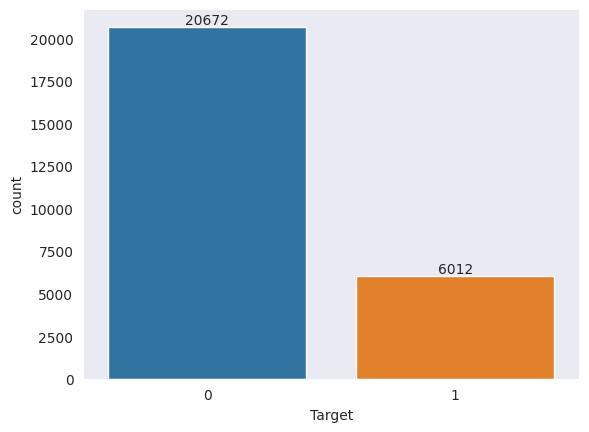

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

countplot = sns.countplot(data = labels.reset_index(), x = 'Target')
for label in countplot.containers:
    countplot.bar_label(label)

In [ ]:
pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.0 MB/s eta 0:00:00


As can be seen above in data patients not having Pneumonia are 3 times of those having Pneumonia. Now let us look at some sample images.

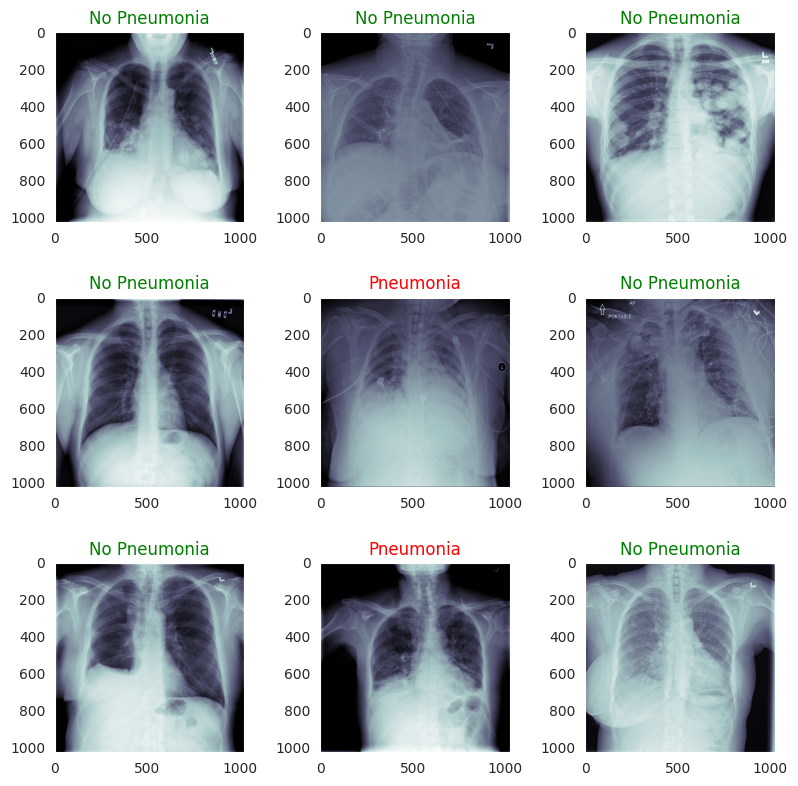

In [ ]:
import pydicom
from pathlib import Path

TRAIN_PATH = Path("/content/drive/MyDrive/pneumonia-detection/stage_2_train_images")
SAVE_PATH = Path("/content/drive/MyDrive/pneumonia-detection/Processed")
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = TRAIN_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array

        label = labels["Target"].iloc[c]

        axis[i][j].imshow(dcm, cmap="bone")
        if (label == 0):
          title = "No Pneumonia"
          titleColor = 'green'
        else:
          title  = "Pneumonia"
          titleColor = 'red'
        axis[i][j].set_title(title, color=titleColor)
        c+=1

In [ ]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

sums = 0
sums_squared = 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = TRAIN_PATH/patient_id  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix

    # Read the dicom file with pydicom and standardize the array
    dcm = pydicom.read_file(dcm_path).pixel_array / 255

    # Resize the image as 1024x1024 is way to large to be handeled by Deep Learning models at the moment
    # Let's use a shape of 224x224
    # In order to use less space when storing the image we convert it to float16
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)

    # Retrieve the corresponding label
    label = labels.Target.iloc[c]

    # 4/5 train split, 1/5 val split
    train_or_val = "train" if c < 24000 else "val"

    current_save_path = SAVE_PATH/train_or_val/str(label) # Define save path and create if necessary
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)  # Save the array in the corresponding directory

    normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image
    if train_or_val == "train":  # Only use train data to compute dataset statistics
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer


  0%|          | 0/26684 [00:00<?, ?it/s]

In [ ]:
mean = sums / 24000
std = np.sqrt(sums_squared / 24000 - (mean**2))
print(f"Mean of Dataset: {mean}, STD: {std}")

Mean of Dataset: 0.4903962485384803, STD: 0.24795070634161256
